In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import torchvision

BATCH_SIZE = 256

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)
# Statt MNIST laden wir nun den FashionMNIST Datensatz
train_data = torchvision.datasets.FashionMNIST(
    root=".",
    train=True,
    download=True,
    transform=transform,
)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.FashionMNIST(
        root=".",
        train=False,
        transform=transform,
    ),
    batch_size=BATCH_SIZE,
)


0


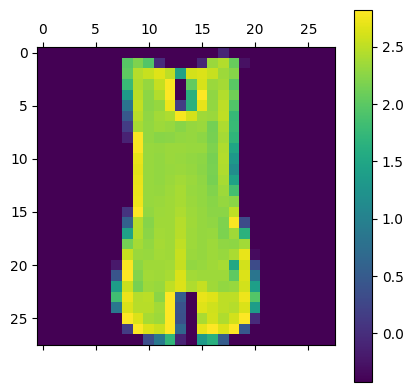

In [6]:
img, label = train_data[4]

plt.matshow(img[0])
plt.colorbar()
print(label)

In [8]:
from norse.torch import ConstantCurrentLIFEncoder

/Users/sophie/miniconda3/envs/neuromorphic_env/lib/python3.9/site-packages/torch/utils/_cxx_pytree.py:238: UserWarning: PyTree type <class 'norse.torch.utils.pytree.LIFParameters'> is a subclass of `collections.namedtuple`, which is already registered in the global namespace. Override it with custom flatten/unflatten functions in namespace 'torch'.
  optree.register_pytree_node(
/Users/sophie/miniconda3/envs/neuromorphic_env/lib/python3.9/site-packages/torch/utils/_cxx_pytree.py:238: UserWarning: PyTree type <class 'norse.torch.utils.pytree.LIFState'> is a subclass of `collections.namedtuple`, which is already registered in the global namespace. Override it with custom flatten/unflatten functions in namespace 'torch'.
  optree.register_pytree_node(
/Users/sophie/miniconda3/envs/neuromorphic_env/lib/python3.9/site-packages/torch/utils/_cxx_pytree.py:238: UserWarning: PyTree type <class 'norse.torch.utils.pytree.LIFFeedForwardState'> is a subclass of `collections.namedtuple`, which is al

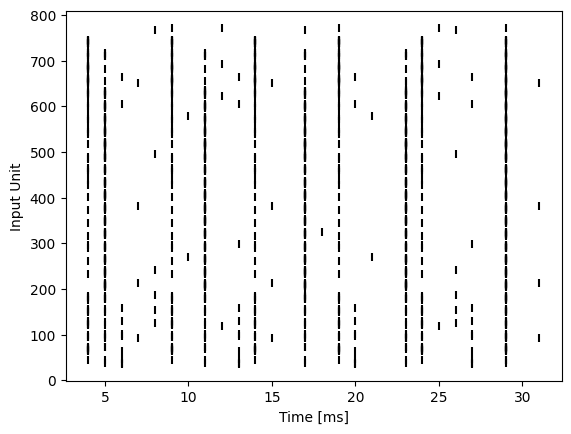

In [9]:
T = 32
example_encoder = ConstantCurrentLIFEncoder(T)


example_input = example_encoder(img)
example_spikes = example_input.reshape(T, 28 * 28).to_sparse().coalesce()
t = example_spikes.indices()[0]
n = example_spikes.indices()[1]

plt.scatter(t, n, marker="|", color="black")
plt.ylabel("Input Unit")
plt.xlabel("Time [ms]")
plt.show()

In [10]:
from norse.torch import PoissonEncoder

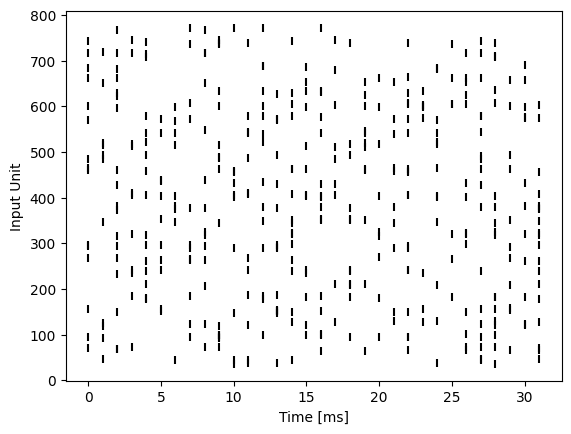

In [11]:
T = 32
example_encoder = PoissonEncoder(T, f_max=20)

example_input = example_encoder(img)
example_spikes = example_input.reshape(T, 28 * 28).to_sparse().coalesce()
t = example_spikes.indices()[0]
n = example_spikes.indices()[1]

plt.scatter(t, n, marker="|", color="black")
plt.ylabel("Input Unit")
plt.xlabel("Time [ms]")
plt.show()

In [16]:
from norse.torch import SpikeLatencyLIFEncoder

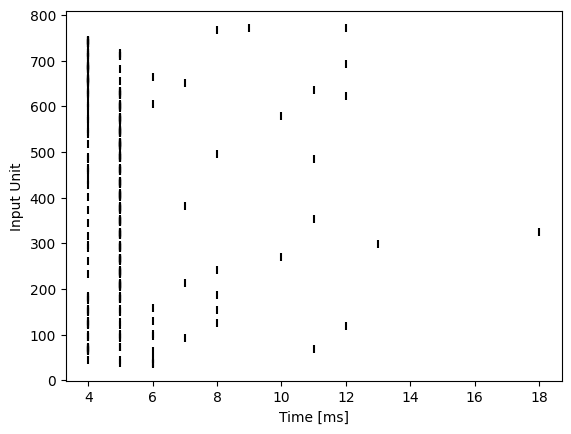

In [18]:
T = 32
example_encoder = SpikeLatencyLIFEncoder(T)


example_input = example_encoder(img)
example_spikes = example_input.reshape(T, 28 * 28).to_sparse().coalesce()
t = example_spikes.indices()[0]
n = example_spikes.indices()[1]

plt.scatter(t, n, marker="|", color="black")
plt.ylabel("Input Unit")
plt.xlabel("Time [ms]")
plt.show()

In [20]:
from norse.torch import LIFParameters, LIFState
from norse.torch.module.lif import LIFCell, LIFRecurrentCell

# Notice the difference between "LIF" (leaky integrate-and-fire) and "LI" (leaky integrator)
from norse.torch import LICell, LIState

from typing import NamedTuple


class SNNState(NamedTuple):
    lif0: LIFState
    readout: LIState


class SNN(torch.nn.Module):
    def __init__(
        self, input_features, hidden_features, output_features, record=False, dt=0.001
    ):
        super(SNN, self).__init__()
        self.l1 = LIFRecurrentCell(
            input_features,
            hidden_features,
            p=LIFParameters(alpha=100, v_th=torch.tensor(0.5)),
            dt=dt,
        )
        self.input_features = input_features
        self.fc_out = torch.nn.Linear(hidden_features, output_features, bias=False)
        self.out = LICell(dt=dt)

        self.hidden_features = hidden_features
        self.output_features = output_features
        self.record = record

    def forward(self, x):
        seq_length, batch_size, _, _, _ = x.shape
        s1 = so = None
        voltages = []

        if self.record:
            self.recording = SNNState(
                LIFState(
                    z=torch.zeros(seq_length, batch_size, self.hidden_features),
                    v=torch.zeros(seq_length, batch_size, self.hidden_features),
                    i=torch.zeros(seq_length, batch_size, self.hidden_features),
                ),
                LIState(
                    v=torch.zeros(seq_length, batch_size, self.output_features),
                    i=torch.zeros(seq_length, batch_size, self.output_features),
                ),
            )

        for ts in range(seq_length):
            z = x[ts, :, :, :].view(-1, self.input_features)
            z, s1 = self.l1(z, s1)
            z = self.fc_out(z)
            vo, so = self.out(z, so)
            if self.record:
                self.recording.lif0.z[ts, :] = s1.z
                self.recording.lif0.v[ts, :] = s1.v
                self.recording.lif0.i[ts, :] = s1.i
                self.recording.readout.v[ts, :] = so.v
                self.recording.readout.i[ts, :] = so.i
            voltages += [vo]

        return torch.stack(voltages)

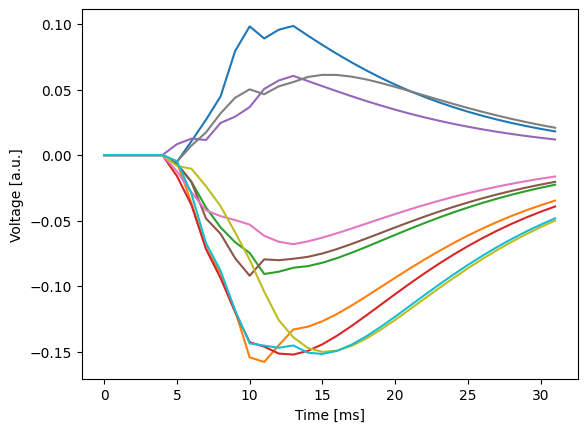

In [22]:
example_snn = SNN(28 * 28, 100, 10, record=True, dt=0.001)

example_readout_voltages = example_snn(example_input.unsqueeze(1))
voltages = example_readout_voltages.squeeze(1).detach().numpy()

plt.plot(voltages)
plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [ms]")
plt.show()

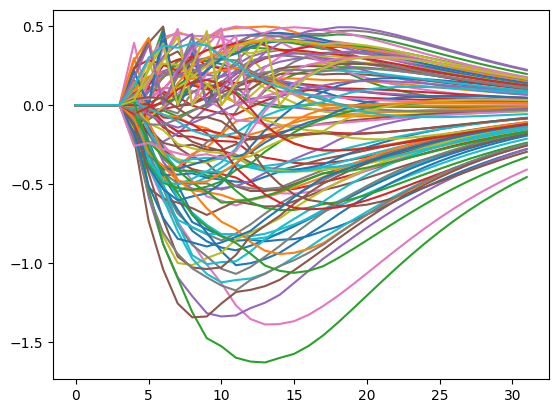

In [24]:
plt.plot(example_snn.recording.lif0.v.squeeze(1).detach().numpy())
plt.show()

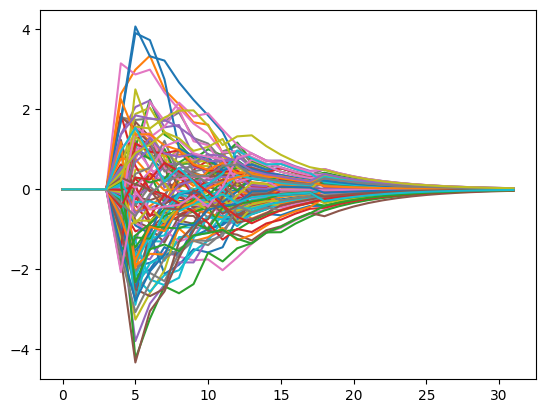

In [26]:
plt.plot(example_snn.recording.lif0.i.squeeze(1).detach().numpy())
plt.show()

In [28]:
def decode(x):
    x, _ = torch.max(x, 0)
    log_p_y = torch.nn.functional.log_softmax(x, dim=1)
    return log_p_y

In [30]:
def decode_last(x):
    x = x[-1]
    log_p_y = torch.nn.functional.log_softmax(x, dim=1)
    return log_p_y

In [32]:
class Model(torch.nn.Module):
    def __init__(self, encoder, snn, decoder):
        super(Model, self).__init__()
        self.encoder = encoder
        self.snn = snn
        self.decoder = decoder

    def forward(self, x):
        x = self.encoder(x)
        x = self.snn(x)
        log_p_y = self.decoder(x)
        return log_p_y

In [34]:
T = 32
LR = 0.002
INPUT_FEATURES = 28 * 28
HIDDEN_FEATURES = 100
OUTPUT_FEATURES = 10

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

model = Model(
    encoder=ConstantCurrentLIFEncoder(
        seq_length=T,
    ),
    snn=SNN(
        input_features=INPUT_FEATURES,
        hidden_features=HIDDEN_FEATURES,
        output_features=OUTPUT_FEATURES,
    ),
    decoder=decode_last,
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

Model(
  (encoder): ConstantCurrentLIFEncoder()
  (snn): SNN(
    (l1): LIFRecurrentCell(input_size=784, hidden_size=100, p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(0.5000), v_reset=tensor(0.), method='super', alpha=tensor(100)), autapses=False, dt=0.001)
    (fc_out): Linear(in_features=100, out_features=10, bias=False)
    (out): LICell(p=LIParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.)), dt=0.001)
  )
)

In [36]:
from tqdm.notebook import tqdm, trange

EPOCHS = 10


def train(model, device, train_loader, optimizer, epoch, max_epochs):
    model.train()
    losses = []

    for (data, target) in tqdm(train_loader, leave=False):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.functional.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    mean_loss = np.mean(losses)
    return losses, mean_loss

In [38]:
def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += torch.nn.functional.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    accuracy = 100.0 * correct / len(test_loader.dataset)

    return test_loss, accuracy

In [40]:
training_losses = []
mean_losses = []
test_losses = []
accuracies = []

torch.autograd.set_detect_anomaly(True)

for epoch in trange(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    training_loss, mean_loss = train(
        model, DEVICE, train_loader, optimizer, epoch, max_epochs=EPOCHS
    )
    test_loss, accuracy = test(model, DEVICE, test_loader, epoch)
    training_losses += training_loss
    mean_losses.append(mean_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)

print(f"final accuracy: {accuracies[-1]}")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2/10


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3/10


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4/10


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5/10


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6/10


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7/10


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8/10


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9/10


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10/10


  0%|          | 0/235 [00:00<?, ?it/s]

final accuracy: 82.08


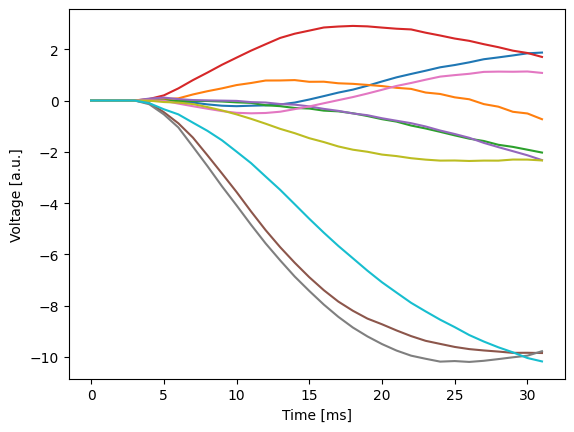

In [42]:
trained_snn = model.snn.cpu()
trained_readout_voltages = trained_snn(example_input.unsqueeze(1))
plt.plot(trained_readout_voltages.squeeze(1).detach().numpy())

plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [ms]")
plt.show()

5 Epochen
final accuracy: 81.37 mit decode

15 Epochs final accuracy: 83.66 mit decode

5 Epochs final accuracy: 81.78 mit decode_last

15 Epochs final accuracy: 83.72 mit decode_last

## Modifying --> SpikeLatencyLIFEncoder

In [44]:
import importlib
from norse.torch.module import encode

encode = importlib.reload(encode)

In [46]:
# from norse.torch.module import encode

T = 32
LR = 0.002
INPUT_FEATURES = 28 * 28
HIDDEN_FEATURES = 100
OUTPUT_FEATURES = 10

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

model = Model(
    encoder=encode.SpikeLatencyLIFEncoder(T),
    snn=SNN(
        input_features=INPUT_FEATURES,
        hidden_features=HIDDEN_FEATURES,
        output_features=OUTPUT_FEATURES,
    ),
    decoder=decode,
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

Model(
  (encoder): SpikeLatencyLIFEncoder()
  (snn): SNN(
    (l1): LIFRecurrentCell(input_size=784, hidden_size=100, p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(0.5000), v_reset=tensor(0.), method='super', alpha=tensor(100)), autapses=False, dt=0.001)
    (fc_out): Linear(in_features=100, out_features=10, bias=False)
    (out): LICell(p=LIParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.)), dt=0.001)
  )
)

In [48]:
training_losses = []
mean_losses = []
test_losses = []
accuracies = []

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    training_loss, mean_loss = train(
        model, DEVICE, train_loader, optimizer, epoch, max_epochs=EPOCHS
    )
    test_loss, accuracy = test(model, DEVICE, test_loader, epoch)
    training_losses += training_loss
    mean_losses.append(mean_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)

print(f"final accuracy: {accuracies[-1]}")

Epoch 1/10


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2/10


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3/10


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4/10


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5/10


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6/10


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7/10


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8/10


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9/10


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10/10


  0%|          | 0/235 [00:00<?, ?it/s]

final accuracy: 82.67


15 Epochs final accuracy: 82.73 mit decode

torch.Size([32, 1, 10])


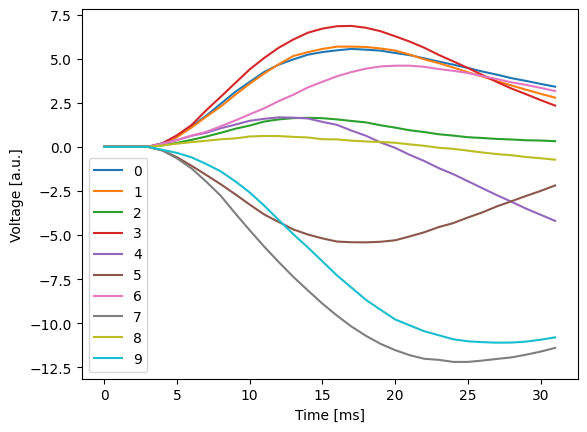

In [50]:
trained_snn = model.snn.cpu()

trained_readout_voltages = trained_snn(example_input.unsqueeze(1))

print(trained_readout_voltages.shape)

for i in range(10):
    plt.plot(
        trained_readout_voltages[:, :, i].squeeze(1).detach().numpy(), label=f"{i}"
    )

plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [ms]")
plt.legend()
plt.show()

## Poison input

In [53]:
T = 32
LR = 0.005
INPUT_FEATURES = 28 * 28
HIDDEN_FEATURES = 200
OUTPUT_FEATURES = 10

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

model = Model(
    encoder=encode.PoissonEncoder(T, f_max=20),
    snn=SNN(
        input_features=INPUT_FEATURES,
        hidden_features=HIDDEN_FEATURES,
        output_features=OUTPUT_FEATURES,
    ),
    decoder=decode,
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

Model(
  (encoder): PoissonEncoder()
  (snn): SNN(
    (l1): LIFRecurrentCell(input_size=784, hidden_size=200, p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(0.5000), v_reset=tensor(0.), method='super', alpha=tensor(100)), autapses=False, dt=0.001)
    (fc_out): Linear(in_features=200, out_features=10, bias=False)
    (out): LICell(p=LIParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.)), dt=0.001)
  )
)

In [55]:
training_losses = []
mean_losses = []
test_losses = []
accuracies = []

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    training_loss, mean_loss = train(
        model, DEVICE, train_loader, optimizer, epoch, max_epochs=EPOCHS
    )
    test_loss, accuracy = test(model, DEVICE, test_loader, epoch)
    training_losses += training_loss
    mean_losses.append(mean_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    # print(f"epoch: {epoch}, mean_loss: {mean_loss}, test_loss: {test_loss}, accuracy: {accuracy}", flush=True)

print(f"final accuracy: {accuracies[-1]}")

Epoch 1/10


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2/10


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3/10


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4/10


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5/10


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6/10


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7/10


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8/10


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9/10


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10/10


  0%|          | 0/235 [00:00<?, ?it/s]

final accuracy: 78.42


15 Epochs final accuracy: 78.13 mit decode


torch.Size([32, 1, 10])


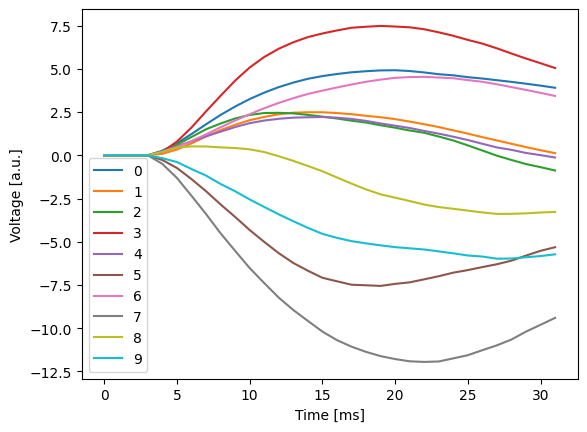

In [58]:
trained_snn = model.snn.cpu()

trained_readout_voltages = trained_snn(example_input.unsqueeze(1))

print(trained_readout_voltages.shape)

for i in range(10):
    plt.plot(
        trained_readout_voltages[:, :, i].squeeze(1).detach().numpy(), label=f"{i}"
    )

plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [ms]")
plt.legend()
plt.show()

In [60]:
from norse.torch.module.leaky_integrator import LILinearCell
from norse.torch.functional.lif import LIFFeedForwardState
from norse.torch.functional.leaky_integrator import LIState

from typing import NamedTuple


class ConvNet(torch.nn.Module):
    def __init__(self, num_channels=1, feature_size=28, method="super", alpha=100):
        super(ConvNet, self).__init__()

        self.features = int(((feature_size - 4) / 2 - 4) / 2)

        self.conv1 = torch.nn.Conv2d(num_channels, 20, 5, 1)
        self.conv2 = torch.nn.Conv2d(20, 50, 5, 1)
        self.fc1 = torch.nn.Linear(self.features * self.features * 50, 500)
        self.lif0 = LIFCell(p=LIFParameters(method=method, alpha=alpha))
        self.lif1 = LIFCell(p=LIFParameters(method=method, alpha=alpha))
        self.lif2 = LIFCell(p=LIFParameters(method=method, alpha=alpha))
        self.out = LILinearCell(500, 10)

    def forward(self, x):
        seq_length = x.shape[0]
        batch_size = x.shape[1]

        # specify the initial states
        s0 = s1 = s2 = so = None

        voltages = torch.zeros(
            seq_length, batch_size, 10, device=x.device, dtype=x.dtype
        )

        for ts in range(seq_length):
            z = self.conv1(x[ts, :])
            z, s0 = self.lif0(z, s0)
            z = torch.nn.functional.max_pool2d(z, 2, 2)
            z = 10 * self.conv2(z)
            z, s1 = self.lif1(z, s1)
            z = torch.nn.functional.max_pool2d(z, 2, 2)
            z = z.view(-1, 4**2 * 50)
            z = self.fc1(z)
            z, s2 = self.lif2(z, s2)
            v, so = self.out(torch.nn.functional.relu(z), so)
            voltages[ts, :, :] = v
        return voltages

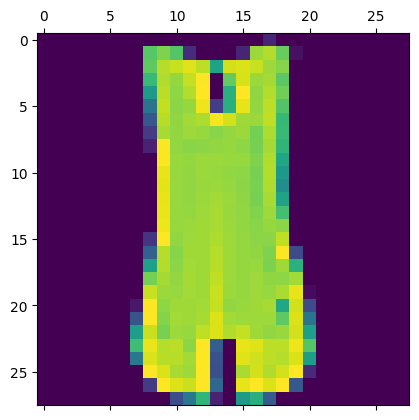

0


In [62]:
img, label = train_data[4]

plt.matshow(img[0])
plt.show()
print(label)

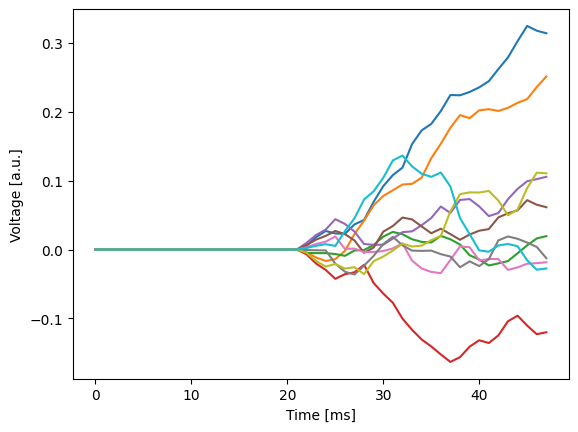

In [64]:
T = 48
example_encoder = encode.ConstantCurrentLIFEncoder(T)
example_input = example_encoder(img)
example_snn = ConvNet()
example_readout_voltages = example_snn(example_input.unsqueeze(1))

plt.plot(example_readout_voltages.squeeze(1).detach().numpy())
plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [ms]")
plt.show()

In [66]:
T = 48
LR = 0.001
EPOCHS = 5  # Increase this for improved accuracy

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

model = Model(
    encoder=encode.ConstantCurrentLIFEncoder(T), snn=ConvNet(alpha=80), decoder=decode
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

Model(
  (encoder): ConstantCurrentLIFEncoder()
  (snn): ConvNet(
    (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
    (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
    (fc1): Linear(in_features=800, out_features=500, bias=True)
    (lif0): LIFCell(p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(80)), dt=0.001)
    (lif1): LIFCell(p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(80)), dt=0.001)
    (lif2): LIFCell(p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(80)), dt=0.001)
    (out): LILinearCell()
  )
)

In [68]:
training_losses = []
mean_losses = []
test_losses = []
accuracies = []

for epoch in trange(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    training_loss, mean_loss = train(
        model, DEVICE, train_loader, optimizer, epoch, max_epochs=EPOCHS
    )
    test_loss, accuracy = test(model, DEVICE, test_loader, epoch)
    training_losses += training_loss
    mean_losses.append(mean_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)

print(f"final accuracy: {accuracies[-1]}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2/5


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3/5


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4/5


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5/5


  0%|          | 0/235 [00:00<?, ?it/s]

final accuracy: 84.66


torch.Size([48, 1, 10])


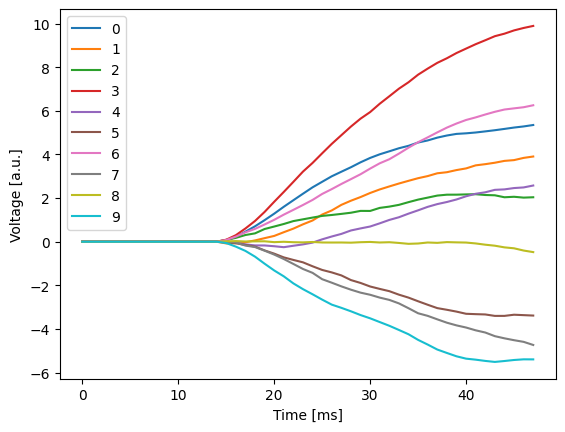

In [70]:
trained_snn = model.snn.cpu()

trained_readout_voltages = trained_snn(example_input.unsqueeze(1))

print(trained_readout_voltages.shape)

for i in range(10):
    plt.plot(
        trained_readout_voltages[:, :, i].squeeze(1).detach().numpy(), label=f"{i}"
    )

plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [ms]")
plt.legend()
plt.show()

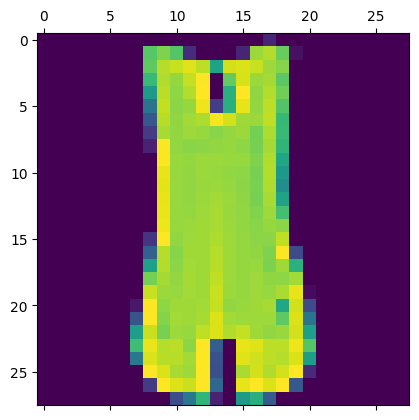

In [72]:
plt.matshow(np.squeeze(img, 0))